In [1]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from scipy import stats
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.plot_data as plot
import models.transforms as transforms
import algorithms.teaching_algs as algs
import evals.teaching_evals as evals
import utils.gen_triplets as gen
from utils.tste import tste as tste
from utils.utils import auto_split

sns.set_theme()
def get_ci(samples, confidence=0.95):  return stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)


SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 35
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
color_list = ['k','y','m','g','c','r','b','lime']
marker_list = ['o','s','^','D','x','p','*','8']
linestyle_list = ['solid','dashed','dashdot','dotted','solid','dashed','dashdot','dotted']

In [1]:
import cx_Oracle

In [2]:
connection = cx_Oracle.connect(dsn = "DBCON.LD")

DatabaseError: DPI-1047: Cannot locate a 64-bit Oracle Client library: "libclntsh.so: cannot open shared object file: No such file or directory". See https://cx-oracle.readthedocs.io/en/latest/user_guide/installation.html for help

## concat-embed experiments

In [12]:
def get_data(dataset, dist):    
    transform = transforms.bird_transform()
    train = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/train", transform=transform)
    test = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/test", transform=transform)
    x_train = np.array([x[0].numpy() for x in train])
    x_test = np.array([x[0].numpy() for x in test])
    y_train = np.array([x[1] for x in train])
    y_test = np.array([x[1] for x in test])

    lpips_test = pickle.load(open(f"data/dist/lpips/{dataset}/lpips.alex.train_test.pkl","rb"))
    prolific_test = pickle.load(open("data/dist/prolific/bm/train_test.pkl","rb"))

    if dist == "lpips":
        dist_M = lpips_test 
        train_triplets = pickle.load(open(f"data/triplets/{dataset}/lpips/train_triplets.pkl","rb"))
        train_triplets = gen.filter_train_triplets(train_triplets, y_train)
        z = tste(np.array(train_triplets), no_dims=50, max_iter=100)
    elif dist == "prolific":
        dist_M = prolific_test
        z = pickle.load(open("data/embeds/bm_prolific/TN_train_d50_seed42.pkl","rb"))

    return dist_M, z, y_train, y_test

def rand_score(dist_M, m, y_train, y_test, n_trials=1000):
    random_scores = np.array([evals.eval_KNN(dist_M, algs.random(y_train, m), y_train, y_test) for _ in range(n_trials)])
    random_ci = get_ci(random_scores)
    random_score = random_scores.mean()
    return random_score, random_ci

def full_rand_score(m_range, dist_M, y_train, y_test):
    full_score = evals.eval_KNN(dist_M, np.arange(len(y_train)), y_train, y_test, k=1)
    random_scores = []
    random_cis = []
    for m in m_range:
        random_score, random_ci = rand_score(dist_M, m, y_train, y_test)
        random_scores.append(random_score)
        random_cis.append(random_ci)
    random_scores = np.array(random_scores)
    random_cis = np.array(random_cis)
    return full_score, random_scores

def run_experiments(m_range, dist_M, teaching_alg, z, y_train, y_test):
    full_scores, random_scores = full_rand_score(m_range, dist_M, y_train, y_test)
    nn_scores, CV_scores, el_scores, wCV_scores, nn_double_scores = [], [], [], [], []

    sim_M = evals.dist2sim(dist_M)
    concat_z, idx = evals.concat_embeds(z, y_train)
    for m in m_range:
        S_concat = teaching_alg(concat_z, m)
        S_pairs = idx[S_concat]
        S_single = teaching_alg(z, m)
        nn_scores.append(evals.eval_KNN(dist_M, S_single, y_train, y_test))
        CV_scores.append(evals.eval_CV(sim_M, S_pairs, y_train, y_test, weighted=False, sim=True))
        wCV_scores.append(evals.eval_CV(sim_M, S_pairs, y_train, y_test, weighted=True, sim=True))

    for m in m_range*2:
        S_single = teaching_alg(z, m)
        nn_double_scores.append(evals.eval_KNN(dist_M, S_single, y_train, y_test))

    results = {"full_scores": [full_scores]*len(m_range), 
        "random_scores": random_scores,
        "1NN_scores": nn_scores,
        "CV_scores": CV_scores,
        "wCV_scores": wCV_scores,
        "1NN_double_scores": nn_double_scores,
        }

    return results

def plot_results(results, m_range, title):
        legend = [score.replace("_scores","") for score in results]
        configs = {     "full_scores":          ["k", 2, "",  "dashed"], 
                        "random_scores":        ["y", 2, "",  "dashed"],
                        "1NN_scores":           ["c", 4, "o", "solid"],
                        "CV_scores":            ["r", 4, "s", "dashdot"],
                        "wCV_scores":           ["g", 4, "^", "dotted"],
                        "1NN_double_scores":    ["b", 4, "*", "solid"],}

        sns.set_color_codes("bright")
        plt.figure(figsize=(14,8))
        for score in results.keys():
                config = configs[score]
                _ = plt.plot(m_range, results[score], alpha=0.8, markersize=10,
                color=config[0], lw=config[1], marker=config[2], linestyle=config[3])

        plt.xticks(m_range)
        plt.xlabel("m")

        plt.legend(legend, loc="lower center", ncol=len(results))
        plt.title(title)

In [17]:
dataset = "bird"
dist = "lpips"
dist_M, z, y_train, y_test = get_data(dataset, dist)

0.8756449265775896


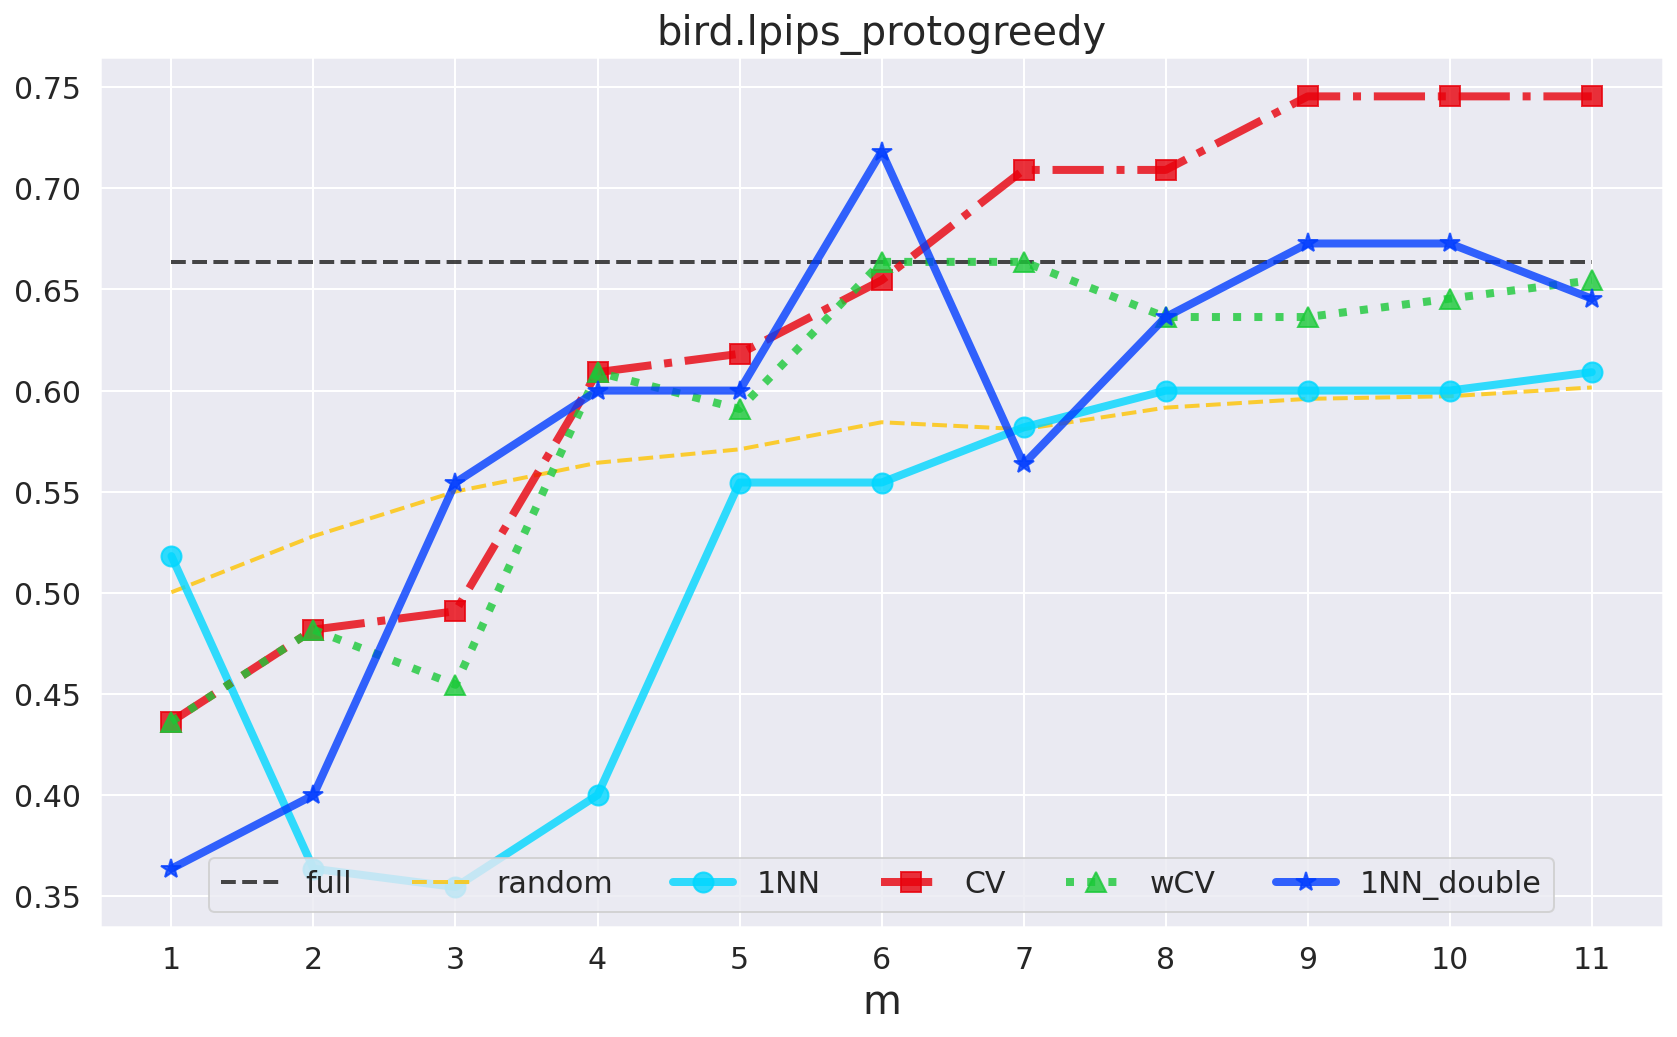

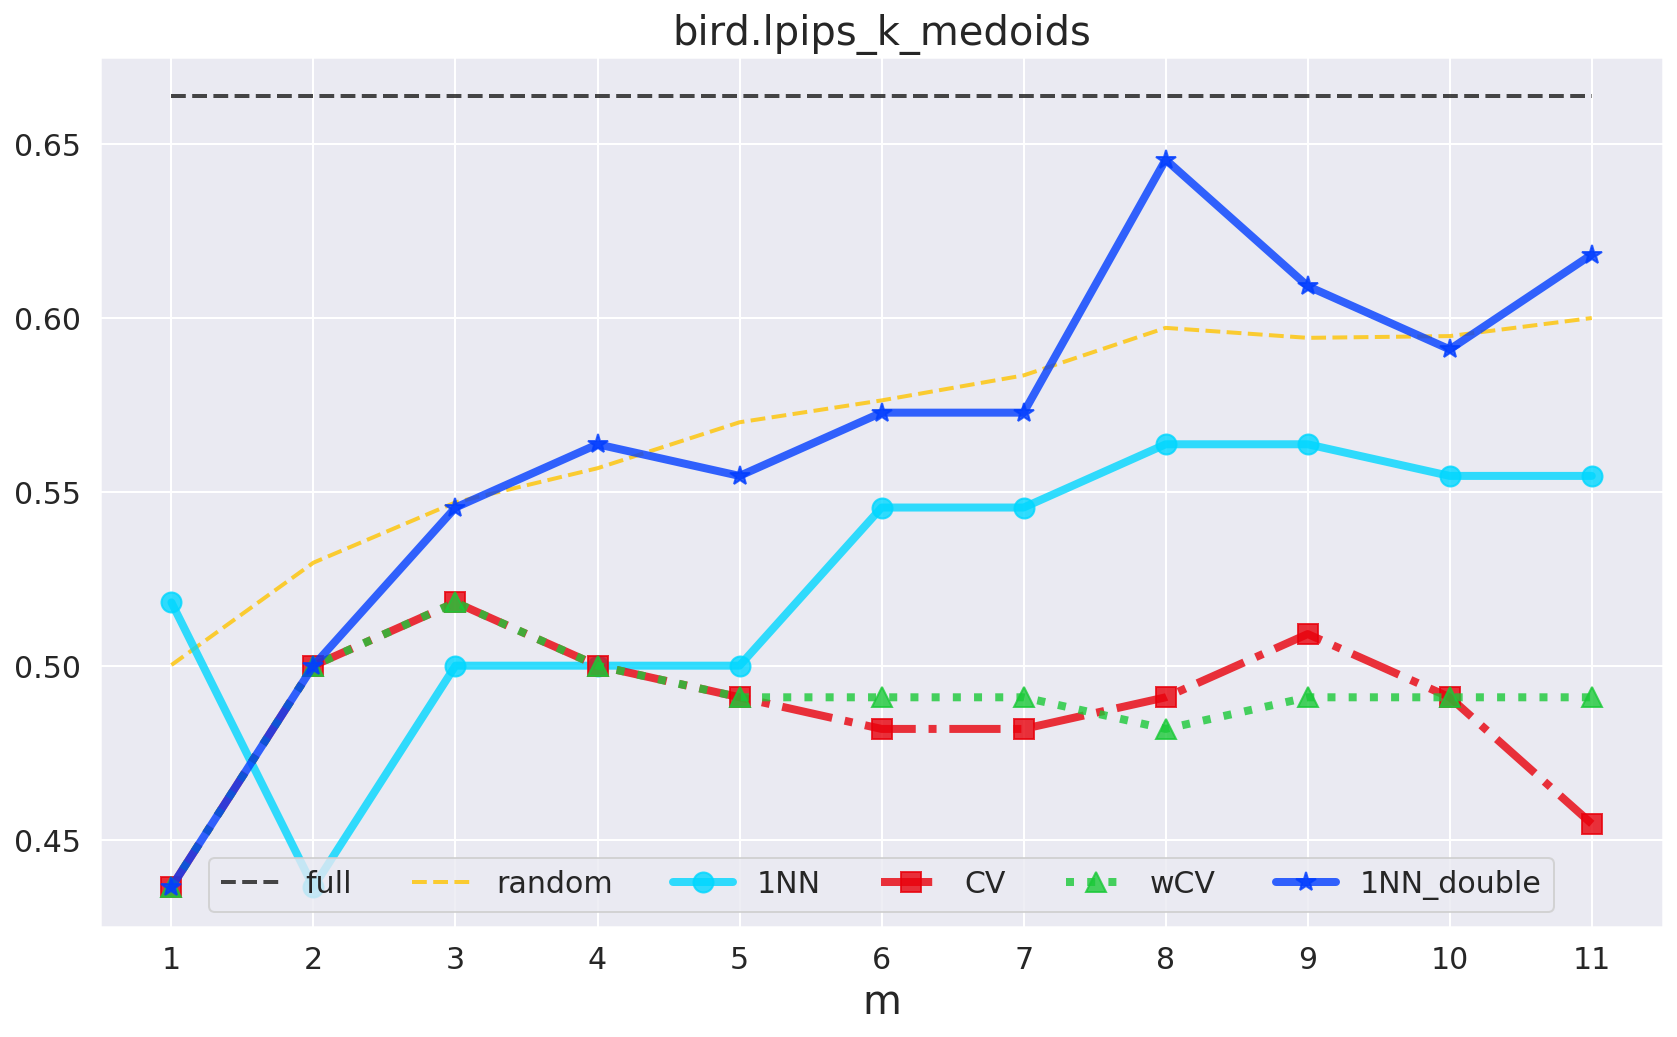

In [18]:
alg_names = ["protogreedy", "k_medoids"]
teaching_algs = [algs.protogreedy, algs.k_medoids, ]
m_range = np.arange(1,12)

for alg, alg_name in zip(teaching_algs, alg_names):
    results = run_experiments(m_range, dist_M, alg, z, y_train, y_test)
    plot_results(results, m_range, f"{dataset}.{dist}_{alg_name}")

In [6]:
sdadasdasdasd

NameError: name 'sdadasdasdasd' is not defined

In [ ]:
def eval_CV(M, pairs, y_train, y_test, weighted, sim=False):
    num_classes = len(np.unique(y_train))
    y_pred = [evals.contrastive_vote(pairs, row, y_train, num_classes, weighted, sim) for row in M]
          
    assert(len(y_pred)==len(y_test))

    return 1-(np.array(y_pred)==np.array(y_test)).sum()/len(y_test), y_pred
sim_M = evals.dist2sim(dist_M)
concat_z, idx = evals.concat_embeds(z, y_train)
S_concat = alg(concat_z, 5)
S_pairs = idx[S_concat]
c1, y1 = eval_CV(sim_M, S_pairs, y_train, y_test, weighted=False, sim=True)
c2, y2 = eval_CV(sim_M, S_pairs, y_train, y_test, weighted=True, sim=True)
y1==y2

In [ ]:
def normalize(data):return (data-np.min(data)) / (np.max(data)-np.min(data))
x = 1/lpips_test

In [ ]:
S1, S2 = algs.kmedoids_contrastive(X, y_train, m)
pairs = algs.group_max(X, S1,S2)
evals.get_CV_score(lpips_alex, pairs, y_train, y_test)

In [ ]:
evals.get_knn_score_lpips(lpips_alex, np.array(pairs).flatten(), y_train, y_test)

In [ ]:
x_pixel = np.array([x.flatten() for x in x_train])
x_50 = pickle.load(open(f"/net/scratch/tianh/ai-driven-tutorial/data/embeds/resn/{dataset}/{dataset}_train_emb50.pkl","rb"))
x_512 = pickle.load(open(f"/net/scratch/tianh/ai-driven-tutorial/data/embeds/resn/{dataset}/{dataset}_train_emb512.pkl","rb"))

In [ ]:
m_range = np.arange(3,21)
lw = 4

In [ ]:
def get_full_random(m_range, lpips, X, y_train, y_test):
    full_score = evals.get_knn_score_lpips(lpips, np.arange(len(y_train)), y_train, y_test, k=1)
    random_scores = []
    random_cis = []
    for m in m_range:
        random_score, random_ci = get_random_score(lpips, m, X, y_train, y_test)
        random_scores.append(random_score)
        random_cis.append(random_ci)
    random_scores = np.array(random_scores)
    random_cis = np.array(random_cis)
    return full_score, random_scores
    
def get_pdash_scores(m_range, lpips, X, y_train, y_test):
    return np.array([evals.get_knn_score_lpips(lpips, algs.protodash(X, m), y_train, y_test, k=1) for m in m_range])

def get_k_medoids_scores(m_range, lpips, X, y_train, y_test):
    return np.array([evals.get_knn_score_lpips(lpips, algs.k_medoids(X, m), y_train, y_test, k=1) for m in m_range])

In [ ]:
def get_df(X):
    agent_df = {}
    for i, (lpips, title) in enumerate([(lpips_alex, "lpips_alex")]):#, (lpips_vgg, "lpips_vgg"), (lpips_squeeze,"lpips_squeeze")]):
        full_score, random_scores = get_full_random(m_range, lpips, X, y_train, y_test)
        k_medoids_scores = get_k_medoids_scores(m_range, lpips, X, y_train, y_test)
        pdash_scores = get_pdash_scores(m_range, lpips, X, y_train, y_test)

        data = {"full_score": [full_score]*len(m_range), 
                "random_score": random_scores,
                "k_medoids_scores": k_medoids_scores,
                "pdash_scores": pdash_scores}
        df = pd.DataFrame(data)
        df = df.set_index(m_range)
        agent_df[title] = df
        return df
        
    return agent_df

In [ ]:
titles = ["image pixel", "resn_d=512", "resn_d=50"]
df_pixel = get_df(x_pixel)
df_512 = get_df(x_512)
df_50 = get_df(x_50)

In [ ]:
sns.set_theme()
plt.rc('legend', fontsize=15)    # legend fontsize

fig, ax = plt.subplots(1,3 , figsize=(8*3, 6), sharey=True, sharex=True)
for i, (df, title) in enumerate(zip([df_pixel, df_512, df_50], titles)):
    sns.lineplot(data=df, lw=4, ax=ax[i], legend=None)
    ax[i].set_xlabel("num_examples")
    ax[i].set_title(title, fontsize=20)
plt.xticks(m_range)
plt.ylim([0.2, 1])
ax[2].legend(["full", "random", "k_medoids", "pdash"])
fig.suptitle(f"lpips_knn: {dataset}", y=1)